In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'src')))
from data_loader import load_fraud_data, load_ip_country_data
from preprocessing import convert_timestamps, add_country_column

# Load data
fraud_df = load_fraud_data("../data/Fraud_Data.csv")
ip_df = load_ip_country_data("../data/IpAddress_to_Country.csv")

# Clean again to ensure consistency
fraud_df = fraud_df.drop_duplicates().dropna()


Time-Based Feature Engineering

In [2]:
fraud_df = convert_timestamps(fraud_df)
print("✅ Created hour_of_day, day_of_week, time_since_signup.")


✅ Created hour_of_day, day_of_week, time_since_signup.


IP to Country Mapping

In [3]:

fraud_df = fraud_df.dropna(subset=['ip_address']).copy()
# Add country column
print("🌍 Mapping IP addresses to countries...")
fraud_df = add_country_column(fraud_df, ip_df)
print("✅ Added 'country' column to fraud data.")

# Preview result
display(fraud_df[['ip_address', 'ip_integer', 'country']].head())


🌍 Mapping IP addresses to countries...
✅ Added 'country' column to fraud data.


,ip_address,ip_integer,country
0,7.327584e+08,732758368,Japan
1,3.503114e+08,350311387,United States
2,2.621474e+09,2621473820,United States
3,3.840542e+09,3840542443,Unknown
4,4.155831e+08,415583117,United States


Top Countries by Transaction Volume

C:\Users\filimon.hailemariam\AppData\Local\Temp\ipykernel_15236\4008955245.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_countries.index, x=top_countries.values, palette='Blues_d')


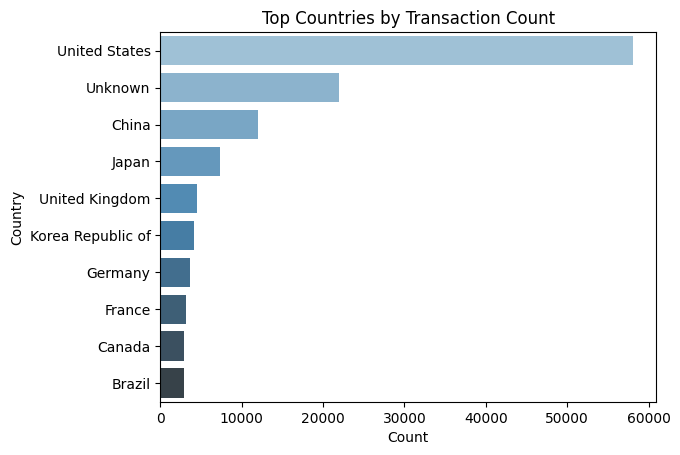

In [4]:
top_countries = fraud_df['country'].value_counts().head(10)

sns.barplot(y=top_countries.index, x=top_countries.values, palette='Blues_d')
plt.title("Top Countries by Transaction Count")
plt.xlabel("Count")
plt.ylabel("Country")
plt.show()

In [5]:
# Save merged/cleaned data to CSV
output_path = "../data/cleaned_fraud_data.csv"
fraud_df.to_csv(output_path, index=False)

print(f"✅ Cleaned data saved to {output_path}")


✅ Cleaned data saved to ../data/cleaned_fraud_data.csv


Time-Based Feature Engineering

In [6]:
# Convert timestamps if not done already
fraud_df['signup_time'] = pd.to_datetime(fraud_df['signup_time'], errors='coerce')
fraud_df['purchase_time'] = pd.to_datetime(fraud_df['purchase_time'], errors='coerce')

# Create time features
fraud_df['hour_of_day'] = fraud_df['purchase_time'].dt.hour
fraud_df['day_of_week'] = fraud_df['purchase_time'].dt.dayofweek
fraud_df['time_since_signup'] = (fraud_df['purchase_time'] - fraud_df['signup_time']).dt.total_seconds()

print("✅ Time-based features created: hour_of_day, day_of_week, time_since_signup")


✅ Time-based features created: hour_of_day, day_of_week, time_since_signup


Visualize Time-based Fraud Patterns

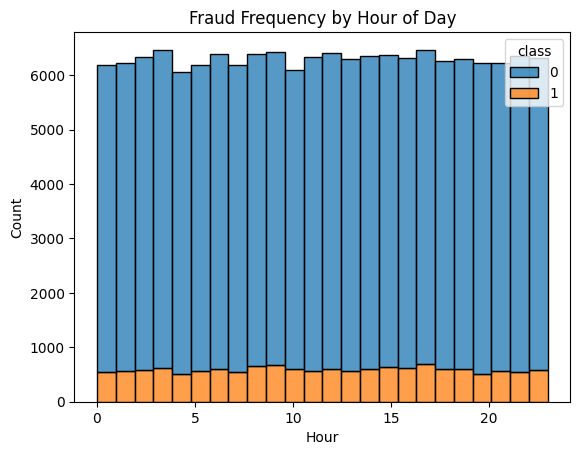

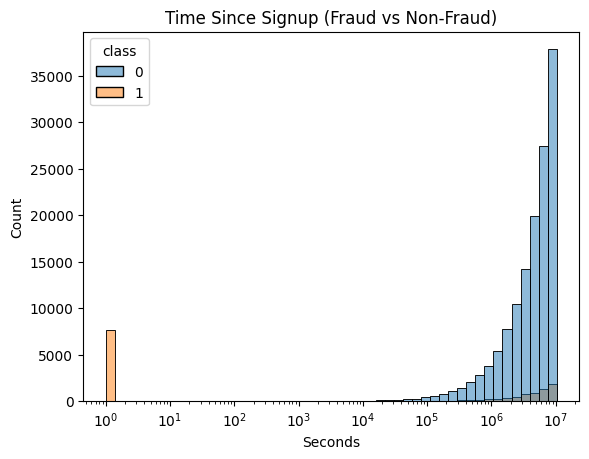

In [7]:
sns.histplot(data=fraud_df, x='hour_of_day', hue='class', multiple='stack', bins=24)
plt.title("Fraud Frequency by Hour of Day")
plt.xlabel("Hour")
plt.show()

sns.histplot(data=fraud_df, x='time_since_signup', hue='class', bins=50, log_scale=True)
plt.title("Time Since Signup (Fraud vs Non-Fraud)")
plt.xlabel("Seconds")
plt.show()


Transaction Frequency & Velocity Features
We'll now calculate:
How many transactions a user or device makes
How quickly those transactions occur

Transaction Frequency and Velocity

In [8]:
# Transaction count per user
import numpy as np
user_counts = fraud_df['user_id'].value_counts().to_dict()
fraud_df['user_transaction_count'] = fraud_df['user_id'].map(user_counts)

# Transaction count per device
device_counts = fraud_df['device_id'].value_counts().to_dict()
fraud_df['device_transaction_count'] = fraud_df['device_id'].map(device_counts)

# Velocity: transactions per IP in a short time window (e.g., 1 hour)
fraud_df = fraud_df.sort_values(by='purchase_time')
fraud_df['purchase_time_unix'] = fraud_df['purchase_time'].astype(np.int64) // 10**9

# Rolling transaction count within 1-hour window per IP
fraud_df['transactions_last_hour'] = (
    fraud_df.groupby('ip_address')['purchase_time_unix']
    .transform(lambda x: x.rolling(window=10, min_periods=1).apply(lambda t: (t.max() - t.min()) <= 3600))
)

print("✅ Added: user_transaction_count, device_transaction_count, transactions_last_hour")


✅ Added: user_transaction_count, device_transaction_count, transactions_last_hour


In [10]:
# Save the feature-engineered dataset
output_path = "../data/engineered_fraud_data.csv"
fraud_df.to_csv(output_path, index=False)

print(f"✅ Feature-engineered data saved to {output_path}")


✅ Feature-engineered data saved to ../data/engineered_fraud_data.csv


Data Transformation :Encode Categorical Features

In [11]:
# Select categorical features to encode
categorical_cols = ['source', 'browser', 'sex', 'country']

# One-Hot Encode
fraud_df_encoded = pd.get_dummies(fraud_df, columns=categorical_cols, drop_first=True)

print(f"✅ One-hot encoding completed. New shape: {fraud_df_encoded.shape}")


✅ One-hot encoding completed. New shape: (151112, 204)


Normalize/Scale Numerical Features

In [12]:
from sklearn.preprocessing import MinMaxScaler

# Define numeric features to scale
numeric_features = [
    'purchase_value',
    'time_since_signup',
    'user_transaction_count',
    'device_transaction_count'
]

scaler = MinMaxScaler()
fraud_df_encoded[numeric_features] = scaler.fit_transform(fraud_df_encoded[numeric_features])

print("✅ Scaled numerical features using MinMaxScaler.")


✅ Scaled numerical features using MinMaxScaler.


Analyze Class Imbalance

⚠️ Class Imbalance:
class
0    136961
1     14151
Name: count, dtype: int64

Class Percentage:
class
0    0.906354
1    0.093646
Name: count, dtype: float64


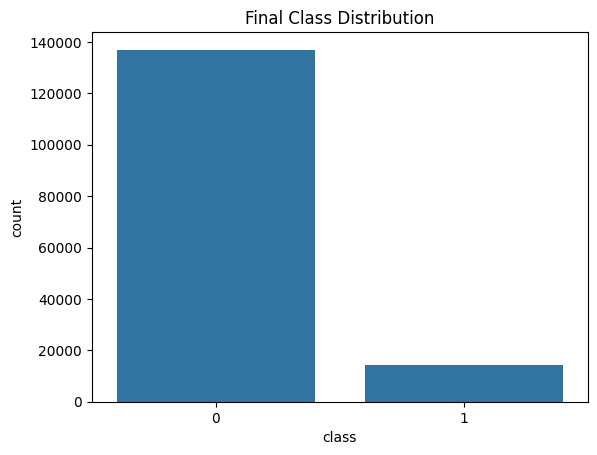

In [13]:
class_distribution = fraud_df_encoded['class'].value_counts()
class_percent = class_distribution / class_distribution.sum()

print("⚠️ Class Imbalance:")
print(class_distribution)
print("\nClass Percentage:")
print(class_percent)

sns.countplot(data=fraud_df_encoded, x='class')
plt.title("Final Class Distribution")
plt.show()


In [14]:
# Save ready-to-model dataset
fraud_df_encoded.to_csv("../data/fraud_data_ready.csv", index=False)
print("💾 Saved processed data to fraud_data_ready.csv")


💾 Saved processed data to fraud_data_ready.csv
